In [1]:
from ml_dl_experiments import settings, show_image_from_source

# **torchvision. Использование моделей и подготовка данных**

Мы познакомились с детекторами Faster R-CNN и FCOS и разобрали их архитектурные различия.

Поняли, что эти модели делают и как они работают в теории. Теперь внаучимся применять эти модели на практике в среде PyTorch. Здесь пригодится библиотека `torchvision`. 

Но есть нюанс — если использовать предобученную модель из библиотеки напрямую, без подготовки данных, неизбежно возникнут ошибки. Модель не умеет работать с сырыми изображениями и аннотациями — она ожидает на вход данные в стандартизированном формате. Этот инженерный аспект часто остаётся за кадром, но критически важен для реального проекта. 

## **Библиотека torchvision**

1. Наборы данных. Это готовые классы для работы с часто используемыми академическими датасетами (torchvision.datasets).
    
2. Модели. Это реализации популярных архитектур нейронных сетей для CV (torchvision.models).
    
3. Трансформации. Это утилиты для предобработки и аугментации изображений (torchvision.transforms).

**torchvision.datasets**

В зависимости от того, какой есть набор данных и как он размечен, можно выбрать тот или иной вид датасета из torchvision и он выдаст объект Dataset, который уже можно будет подавать в DataLoader

```py
import torchvision

# Загружаем тренировочную часть датасета CIFAR10
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',      # куда скачать/где лежат данные
    train=True,         # указываем, что нам нужна тренировочная часть
    download=True       # разрешаем скачивание
)
```

**torchvision.transforms**

Изображения нужно привести к стандартному виду и формату, а также нормализовать. Кроме того, чтобы улучшить качество модели, часто применяют аугментации. `torchvision.transforms` решает все эти задачи.

Основные трансформации:

- ToTensor() преобразует изображение из формата PIL Image или NumPy array в torch.Tensor и масштабирует значения пикселей в диапазон [0.0, 1.0].
- Resize((w, h)) изменяет размер изображения.
- CenterCrop(size) вырезает центральную часть изображения.
- RandomHorizontalFlip(p=0.5) с вероятностью p отражает изображение по горизонтали (типичная аугментация).
- Compose([...]) объединяет несколько трансформаций в единый пайплайн.

Пример:
```py
from torchvision import transforms

# Создаём пайплайн трансформаций
transform_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Применяем трансформации при загрузке датасета
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_pipeline
)

# Теперь каждый элемент датасета будет предварительно обработан
img_tensor, label = train_dataset[0] 
```

**torchvision.models**

Особенно ценная возможность в `torchvision.models` — загрузить не просто архитектуру, а модель с весами, уже обученными на огромном датасете.

Модели в torchvision.models сгруппированы по задачам:

- Модели для классификации изображений: VGG(vgg16, vgg19), ResNet(resnet18, resnet50, resnet101), DenseNet, MobileNet, EfficientNet и т. д.
- Модели для детекции объектов: Faster R-CNN (fasterrcnn_resnet50_fpn), FCOS(fcos_resnet50_fpn), SSD (ssd300_vgg16) и т. д.
- Модели для сегментации изображений.

Пример:
```py
import torch
from torchvision import models
from PIL import Image

# Загружаем модель с лучшими доступными предобученными весами
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)

# Переводим модель в режим оценки
# Отключает Dropout и использует сохраненные статистики для BatchNorm
model.eval()

# Получаем необходимые трансформации для этой модели
preprocess = weights.transforms()

# Загружаем и подготавливаем изображение
img = Image.new('RGB', (500, 300), color = 'red') # Пример изображения
batch = preprocess(img).unsqueeze(0)

# Делаем предсказание
with torch.no_grad(): # Отключаем расчёт градиентов для ускорения
    prediction = model(batch)

# Интерпретируем результат
probabilities = torch.nn.functional.softmax(prediction[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5) 
```

In [1]:
%pip list

Package                   Version            Editable project location
------------------------- ------------------ ------------------------------------------
absl-py                   2.3.1
aiohappyeyeballs          2.6.1
aiohttp                   3.13.2
aiosignal                 1.4.0
albucore                  0.0.24
albumentations            2.0.8
annotated-types           0.7.0
anyio                     4.12.0
argon2-cffi               25.1.0
argon2-cffi-bindings      25.1.0
arrow                     1.4.0
asttokens                 3.0.1
async-lru                 2.1.0
attrs                     25.4.0
audioop-lts               0.2.2
audioread                 3.1.0
babel                     2.17.0
beautifulsoup4            4.14.3
bleach                    6.3.0
blis                      1.3.3
catalogue                 2.0.10
certifi                   2025.4.26
cffi                      2.0.0
charset-normalizer        3.4.2
clearml                   2.0.2
click                     8.

In [3]:
from pathlib import Path
import torchvision

from ml_dl_experiments import settings

weights = torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1
model = torchvision.models.mobilenet_v2(weights=weights)

data_path: Path = Path(settings.SOURCE_PATH + "datasets")
transforms=weights.transforms()
dataset = torchvision.datasets.CIFAR10(
    root = data_path,
    train=False,
    download=True
)

print(len(dataset))

10000


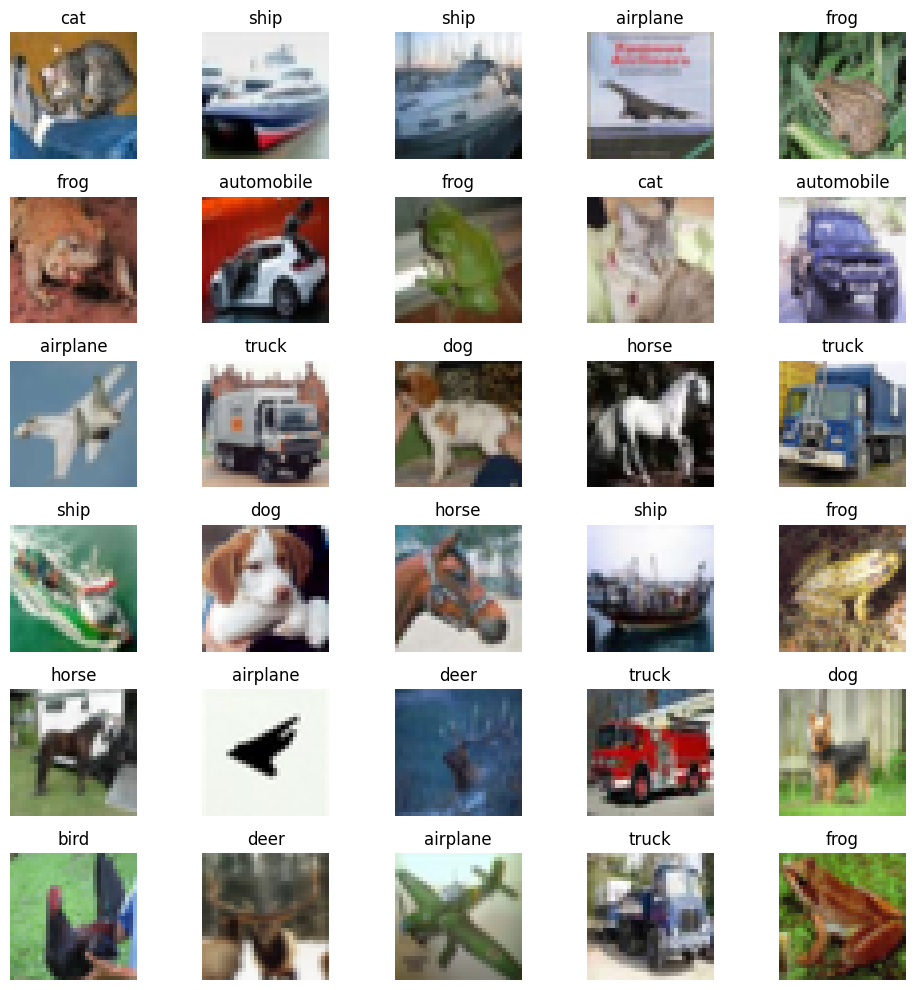

In [25]:
import matplotlib.pyplot as plt

classes: list[str] = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]
fig, ax = plt.subplots(
    nrows=6,
    ncols=5,
    figsize=(10, 10))
images = [(img[0], img[1]) for img in dataset]
for i, img in enumerate(images[:30]):
    row = i // 5
    col = i % 5
    ax[row, col].imshow(img[0])
    ax[row, col].axis("off")
    ax[row, col].set_title(classes[img[1]])
plt.tight_layout()
plt.show()
        

In [48]:
import torch

batch = transforms(dataset[0][0]).unsqueeze(0)

with torch.no_grad():
    prediction = model(batch)
    
print(prediction, prediction.shape, type(prediction), prediction[0].shape, sep='\n')

tensor([[-1.0980e+00, -1.2786e+00, -1.7525e-01, -1.4830e+00, -1.1190e+00,
         -8.4692e-02, -1.1127e+00,  9.0923e-01,  7.4231e-01, -1.4855e+00,
         -1.1371e+00, -3.2008e-01, -7.0954e-01, -6.4226e-01, -1.4490e+00,
         -8.5490e-01, -1.1556e+00, -4.0307e-01, -5.7669e-01, -7.3873e-01,
         -1.9074e+00, -7.7475e-01, -2.0596e+00,  4.0379e-01, -1.0868e+00,
         -8.6540e-01, -2.8577e-01, -1.1789e+00,  2.3568e-01, -4.3830e-01,
         -4.2655e-01, -3.2804e-01,  4.0662e-01,  5.7874e-02,  7.3009e-01,
          5.4667e-01,  2.0614e+00,  4.5078e-01, -9.4515e-02,  1.2009e+00,
         -4.1955e-01,  1.0930e-01, -1.3764e+00, -3.5417e-01, -4.7312e-01,
         -7.8473e-01, -4.6745e-01,  3.0945e-01, -1.3865e+00, -1.5418e+00,
         -1.4045e+00,  7.9706e-01,  2.0023e-01, -4.4169e-01,  7.2923e-01,
         -4.9573e-01,  7.5278e-02, -4.1292e-01, -2.4371e-01,  3.5766e-01,
          1.7064e+00,  1.0726e+00,  8.7379e-01, -2.2959e-02, -2.6313e-02,
          4.1687e-01, -1.9533e-01, -9.

In [53]:
top5_prob, top5_catid = torch.topk(torch.nn.functional.softmax(prediction[0], dim=0), k=5)
categories = weights.meta['categories']
print(top5_prob)
print(top5_catid, top5_catid.shape, sep='\t')
for i in range(top5_prob.size(0)):
    category_name:str  = categories[int(top5_catid[i])]
    probability = top5_prob[i].item()
    print(f"\t{i+1}. Класс: {category_name:<20} | Вероятность: {probability*100:.2f}%") 

tensor([0.0260, 0.0164, 0.0164, 0.0083, 0.0072])
tensor([852, 463, 600, 428, 837])	torch.Size([5])
	1. Класс: tennis ball          | Вероятность: 2.60%
	2. Класс: bucket               | Вероятность: 1.64%
	3. Класс: hook                 | Вероятность: 1.64%
	4. Класс: barrow               | Вероятность: 0.83%
	5. Класс: sunglasses           | Вероятность: 0.72%


**Адаптация датасета**

`torchvision` ожидает, что для каждого изображения получит кортеж (image, target):

- image — тензор изображения, например, формы [3, H, W].
- target — словарь, который должен содержать как минимум два обязательных ключа:
    - boxes. Это torch.Tensor с типом данных torch.float32 и формой (N, 4), где N — количество детекций на изображении. Формат координат: [x_min, y_min, x_max, y_max].
    - labels. Это torch.Tensor с типом данных torch.int64 и формой (N,), где N — количество рамок, а класс 0 зарезервирован для фона (background).

Помимо обязательных ключей target может содержать и другие. Например, ключи для вычисления метрик:

- image_id — torch.Tensor формы (1,). Уникальный идентификатор изображения.
- area — torch.Tensor формы (N,). Площадь каждой рамки.
- iscrowd — torch.Tensor формы (N,). Флаг, указывающий, является ли объект толпой.

Реальные данные обычно другого формата. Чаще всего у нас есть папка с изображениями (.jpg) и папка с аннотациями (например, файлы XML или JSON, описывающие рамки на каждом изображении). Аннотации могут быть в разных типах (VOC XML, COCO JSON, YOLO .txt и т. д.). 

Это не то, что ожидает получить torchvision, так что не получится просто подать сырые данные в модель. 

*Описание набора данных*

Для нашей задачи подойдёт, например, Penn-Fudan-Pedestrian — небольшой датасет пешеходов в городских сценах. Его аннотации представлены масками сегментации, а для torchvision нужны bounding boxes.

```shell
.
├── added-object-list.txt
├── Annotation
├── PedMasks
├── PNGImages
└── readme.txt
```

Сегментационная маска — это одноканальное, целочисленное 2D-изображение, которое имеет точно такие же высоту и ширину, как и исходное изображение. 

Значение каждого пикселя в маске — это не цвет, а целочисленный код (id) класса:
$$
mask[y, x] = c
$$

*Конвертация масок в рамки*

Напишем сам класс-наследник torch.utils.data.Dataset. 

Он должен реализовывать три метода: `__init__, __len__и __getitem__`.

In [10]:
import os
from PIL import Image
import numpy as np
import torch
import torchvision

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        """
        Инициализатор класса.
        
        Args:
            root (str): Путь к корневой папке датасета ('PennFudanPed').
            transforms: Пайплайн трансформаций, которые будут применяться к данным.
        """
        self.root = root
        self.transforms = transforms
        # Загружаем все пути к изображениям и маскам.
        # Отсортируем их, чтобы img[i] соответствовал mask[i].
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(self.root, "PedMasks"))))

    def __len__(self):
        """Возвращает общее количество сэмплов в датасете."""
        return len(self.imgs)

    def __getitem__(self, idx):
        """
        Возвращает один сэмпл (изображение и таргет) по индексу.
        Это сердце нашего датасета, здесь происходит вся магия конвертации.
        """
        # Загружаем изображение и маску по их путям
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        
        # Открываем изображение в формате RGB. Это важно, так как модели ожидают 3 канала
        img = Image.open(img_path).convert("RGB")
        # Маску открываем как есть. У нее один канал
        mask = Image.open(mask_path)
        
        # Конвертируем маску в bounding box'ы
        # Маска - это изображение, где разные объекты размечены
        # разными цветами (разными целочисленными значениями пикселей).
        # Пиксели фона имеют значение 0.
        
        # Конвертируем маску PIL в массив numpy для удобной работы
        mask = np.array(mask)
        
        # Находим все уникальные ID объектов на маске.
        # Например, [0, 1, 2, 5], где 0 - фон, а 1, 2, 5 - id трёх разных пешеходов
        obj_ids = np.unique(mask)
        
        # Первое значение - это фон (0), поэтому мы его убираем.
        obj_ids = obj_ids[1:] # -> [1, 2, 5]

        # Теперь для каждого id объекта нужно создать отдельную бинарную маску
        # и найти по ней координаты bounding box
        binary_masks = (mask == obj_ids[:, None, None])

        # Получаем bounding box'ы из бинарных масок
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            # Находим все координаты (y, x), где значение в маске равно True
            pos = np.where(binary_masks[i])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            boxes.append([xmin, ymin, xmax, ymax])

        # Собираем словарь target в требуемом формате
        
        # Конвертируем список с боксами в torch.Tensor типа float32
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # В этом датасете у нас только один класс - пешеход
        # Поэтому всем объектам присваиваем метку 1
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        # Добавляем остальные поля, которые могут понадобиться
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # Предположим, что все объекты не являются толпой
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Собираем финальный словарь target
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["filename"] = img_path

        # 4. Применяем трансформации (если они есть)
        if self.transforms is not None:
             img = torchvision.transforms.functional.to_tensor(img)  # type:ignore
        else:
             # Если трансформаций нет, всё равно нужно конвертировать img в тензор
             img = torchvision.transforms.functional.to_tensor(img)  # type:ignore


        return img, target

Когда `DataLoader` запросит у него dataset[i], наш класс выполнит шаги в __getitem__ и вернёт отформатированную пару (image_tensor, target_dict), готовую к отправке в модель. 

Этот принцип работает для любого кастомного датасета.

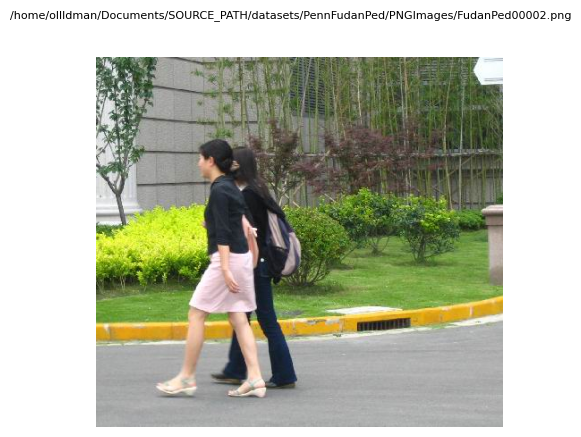

In [13]:
import matplotlib.pyplot as plt

data_root: str = settings.SOURCE_PATH + "datasets/PennFudanPed"
dataset = PennFudanDataset(data_root)

plt.imshow(dataset[1][0].permute(1,2,0))
plt.suptitle(dataset[1][1]['filename'], size=8)
plt.axis('off')
plt.show()

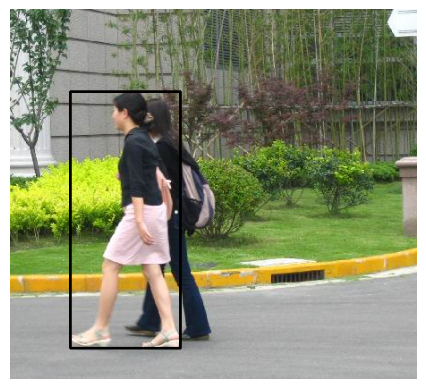

In [25]:
import cv2

image = cv2.imread(dataset[1][1]['filename'])
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
box = dataset[1][1]['boxes'][0].tolist()
new_img = cv2.rectangle(img=img,pt1=(int(box[0]), int(box[1])), pt2=(int(box[2]), int(box[3])), color=3, thickness=2)
plt.imshow(new_img)
plt.axis('off')
plt.show()

Задание 2...

**Конвертация масок в рамки**

**Функция collate_fn**

## **Сравнение моделей YOLO, FCOS и Faster R-CNN**

На этом шаге важно не просто использовать одну модель, а осмысленно выбирать между разными архитектурами.

Архитектуры детекторов объектов бывают фундаментально разными. Все они балансируют между скоростью и точностью, и каждый подход находит свою точку баланса. Чтобы разобраться, что когда уместно применить, лучше всего сравнить модели на практике! 

Мы пропустим через каждую модель один и тот же набор данных, на практике измерим их производительность, визуально оценим качество предсказаний на сложных примерах и проанализируем их характерные ошибки.

**Теоретический обзор архитектур**

| Метод       | Тип детектора   | Основной принцип работы                                                                 | Преимущества                                      | Недостатки                                              |
|-------------|------------------|------------------------------------------------------------------------------------------|---------------------------------------------------|---------------------------------------------------------|
| **Faster R-CNN** | Двухэтапный      | 1. RPN генерирует предложения регионов.<br>2. Детектор классифицирует и уточняет рамки каждого региона. | Очень высокая точность                            | Большие вычислительные затраты, медленная обработка    |
| **FCOS**        | Однопроходный    | Для каждой точки на изображении предсказывает принадлежность к объекту и расстояния до границ рамки. Без якорей. | Хороший баланс скорости и точности, проще архитектура | Генерирует много кандидатов, требуется NMS              |
| **YOLOv10**     | Однопроходный    | Одновременно определяет объекты и подавляет избыточные предсказания на этапе прямого прохода. | Высокая скорость и эффективность end-to-end       | Ниже точность по сравнению с двухэтапными в сложных сценах |

**Подготовка к эксперименту**

**Особенности определения моделей**

**Скорость моделей детекции**

## **MMdetection — стандарт современного проекта**

Ранее мы на практике сравнили три ключевые архитектуры: двухстадийного Faster R-CNN, одностадийного YOLO и anchor-free FCOS. 

При этом вручную запускали инференс, анализировали результаты и измеряли производительность, чтобы понять различия подходов. Это трудоёмкий процесс. В реальной разработке для каждого эксперимента нужна уникальная кодовая база, так что воспроизводить результаты и тестировать новые модели — трудозатратно. Высокие инженерные затраты — главная проблема экспериментирования. 

Чтобы решить эту проблему, в индустрии и академических кругах разработали унифицированные фреймворки. Они стандартизируют и автоматизируют всю инженерную обвязку, позволяя человеку сосредоточиться на главном: архитектуре, данных и гипотезах. В уроке вы познакомитесь с золотым стандартом в этой области — **MMDetection**.

Сейчас мы перейдём от анализа отдельных моделей к построению полноценных, воспроизводимых проектов. Освоив **MMDetection**, мы получим доступ к десяткам SOTA-архитектур и научимся применять промышленный подход к решению задач компьютерного зрения.

**Проблемы ручного подхода**

Основные проблемы такие: 

- **Огромное количество кода.** Сотни, а иногда тысячи строк кода, который не относится напрямую к исследованию, а является инженерной обвязкой.
    
- **Сложность воспроизведения.** При попытке воспроизвести результаты из статьи метрики могут не совпасть. Почему? Может, неправильно реализован learning rate scheduler? Или аугментации были другими? Возможных причин много.
    
- **Трудность в экспериментах.** Хочется попробовать другой backbone (например, сменить ResNet-50 на VGG)? Придётся переписывать значительную часть кода.

**MMDetection**

**MMDetection — это open-source библиотека**, построенная на PyTorch, которая решает все эти проблемы. Это унифицированный фреймворк, который часто используется для продакшн-решений задач детекции и других. 

Преимущества фреймворка: 

1. Обеспечивает воспроизводимость. Все параметры эксперимента описываются в одном файле конфигурации.
    
2. Содержит зоопарк моделей. В MMDetection есть огромная коллекция уже обученных моделей на стандартных датасетах (COCO и другие). Можно сразу использовать готовую модель, а можно — дообучить её на своих данных, экономя недели на обучение с нуля.
    
3. Обеспечивает модульность и гибкость. Модель представлена как конструктор. Нужно заменить backbone? Просто измените одну строчку в config-файле. Нужно добавить новую аугментацию? Добавьте один блок в пайплайн. Все компоненты взаимозаменяемы.
    
4. Поддерживает SOTA-решения. Команда MMDetection оперативно добавляет реализации новых моделей. Удобно использовать передовые технологии, не реализуя их с нуля.